In [ ]:
# Data to upload : 

# 'converted_data.csv' 

# Note: This code will take ~ 60-90 seconds to run. 

<font color='blue'>Cell 1
Importing libraries

In [ ]:
import numpy as np
import pandas as pd

# Reading and verifying data

<font color='blue'>Cell 2
Reading in the data set

In [ ]:
data = pd.read_csv('converted_data.csv')
used_data = data.copy()
used_data = used_data.iloc[:,1:]
used_data.head()

,Protein,AA Sequence,SST3 Sequence,Length,B Count,C Count,H Count,numB,numC,numH
0,>VACUOLAR MORPHOGENESIS PROTEIN VAM7; SWP:P329...,KMSEKLRIKVDDVKINPKYVLYGVSTPNKRLYKRYSEFWKLKTRLE...,CCCCCBBBBBCBBBBCCCCBBBBBBBBCBBBBBBHHHHHHHHHHHH...,117.0,0.196581,0.452991,0.350427,23.0,53.0,41.0
1,>IRON(III) DICITRATE TRANSPORT PROTEIN FECA; S...,NDVFEHAGARDVIRREDFAKTGATTREVLNRIPGVSAPENNGTGSH...,CCCCCCCBBBBBBCHHHHHHCCCCCCHHHHCCCCBBBCCCCCCCCC...,633.0,0.633491,0.333333,0.033175,401.0,211.0,21.0
2,>DIPETALIN; SWP:O96790; PDB:1KMAA,FQGNPCECPRALHRVCGSDGNTYSNPCMLTCAKHEGNPDLVQVHEG...,CCCCCCCCCCCCBBBBBCCCBBBBCHHHHHHHHHHCCCCCCCCCCC...,55.0,0.163636,0.654545,0.181818,9.0,36.0,10.0
3,>CHEMOTAXIS PROTEIN CHEY; SWP:P07366; PDB:1KMIZ,SIKPADEHSAGDIIARIGSLTRMLRDSLRELGLDQAIAEAAEAIPD...,CCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHCCHHHH...,177.0,0.000000,0.175141,0.824859,0.0,31.0,146.0
4,>CHEMOTAXIS PROTEIN CHEY; SWP:P06143; PDB:1KMIY,ADKELKFLVVDDFSTMRRIVRNLLKELGFNNVEEAEDGVDALNKLQ...,CCCCBBBBBBBCCCHHHHHHHHHHHHHCCCBBBBBCCHHHHHHHHH...,128.0,0.257812,0.304688,0.437500,33.0,39.0,56.0


<font color='blue'>Cell 3
Removing proteins with non standard amino acids

In [ ]:
def remove_non_standard_aa():
  num_nonstd = 0
  aa_nonstd = []
  num_prot = len(used_data)
  for prot in range(num_prot):
    if used_data.iloc[prot,1].find('X') != -1:
      num_nonstd += 1
      aa_nonstd.append(prot)
    elif used_data.iloc[prot,1].find(';') != -1:
      num_nonstd += 1
      aa_nonstd.append(prot)
  return aa_nonstd

aa_nonstd = remove_non_standard_aa()
used_data = used_data.drop(used_data.index[aa_nonstd])

<font color='blue'>Cell 4
Data set verification

In [ ]:
#Check the dataset to make sure no data is missing and Check the class labels
def verify_dataset(data):
  #if any of the rows have missing value return datas missing
  data_found = 1
  for each_column in data.columns:
    if data[each_column].isnull().any():
            print("Data missing in Column " + each_column)
            #if any rows are not missing return Dataset is complete. No missing value
            quit()
    if data_found == 1:
        print("Dataset is complete. No missing values")
    return

verify_dataset(used_data)

Dataset is complete. No missing values


# Data encoding

<font color='blue'>Cell 5
Data set splitting function

In [ ]:
#The "sample" function will sort the data rows (proteins) randomly
def split_dataset_test_train(data,limit,train_size):
  data = data.sample(frac=limit).reset_index(drop=True)
  training_data = data.iloc[:int(train_size * len(data))].reset_index(drop=True)
  testing_data = data.iloc[int(train_size * len(data)):].reset_index(drop=True)
  return training_data, testing_data


<font color='blue'>Cell 6
Creating the amino acid encoding alphabet

In [ ]:
#Defining codes for the alphabet
aa_codes = np.array(['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T',
            'V','W','Y','Null'])
#An identity matrix is one such that all diagonal elements are equal to 1, while the rest are 0
aa_alphabet = pd.DataFrame(data=np.identity(21), columns=aa_codes)


<font color='blue'>Cell 7
Creating the secondary structure encoding alphabet

In [ ]:
#Defining the encoding matrix for the structures
sst3_codes = np.array(['B','C','H'])
sst3_alphabet = pd.DataFrame(data=np.identity(3), columns=sst3_codes)

<font color='blue'>Cell 8
Amino acid encoding and windowing function

In [ ]:
def aa_encode(data_set):
    aa_encoded = np.empty((0,(window_size*21)))
    null_size = int(window_size/2)
    null_pad = [aa_alphabet['Null']]*null_size
    null_pad = np.array(null_pad)
    
    #This function iterates over all proteins in the data set provided
    for i in range(len(data_set)):

        #A list is created containing the bit sequences for amino acids in the current protein
        to_encode = [aa_alphabet[aa] for aa in data_set.iloc[i,1]]
        to_encode = np.array(to_encode)

        #The encoded sequence is then padded with the "Null" sequence
        to_encode = np.concatenate((null_pad,to_encode), axis=0)
        to_encode = np.concatenate((to_encode,null_pad), axis=0)  
        
        #The encoded sequences representing the amino acids are gathered in groups according to the window size
        X_data = [to_encode[top:top+window_size,:].flatten() for top in range(len(data_set.iloc[i,1]))]
        X_data = np.array(X_data)
        
        #The current protein's data is added to the array of all encoded proteins
        aa_encoded = np.concatenate((X_data,aa_encoded),axis=0)
    return aa_encoded


<font color='blue'>Cell 9
Secondary structure encoding function

In [ ]:
def sst3_encode(data_set):
    sst3_encoded = np.empty((0,3))
    for i in range(len(data_set)):
        to_encode = [sst3_alphabet[sst3] for sst3 in data_set.iloc[i,2]]
        to_encode = np.array(to_encode)
        sst3_encoded = np.concatenate((to_encode,sst3_encoded),axis=0)
    return sst3_encoded


<font color='blue'>Cell 10
Running the train/test splitting function

In [ ]:
'''Change data_frac'''
data_frac = 0.10         #data_frac is the fraction of the total data to use for both training and test sets
train_frac = 0.7         #train_frac is the fraction of the used set to use for training

train_data, test_data = split_dataset_test_train(used_data,data_frac,train_frac)

<font color='blue'>Cell 11
Encoding the training/testing input and output data

In [ ]:
window_size = 17
X_train = aa_encode(train_data)
X_test = aa_encode(test_data)

y_train = sst3_encode(train_data)
y_test = sst3_encode(test_data)

<font color='blue'>Cell 12
Importing keras packages

In [ ]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential

<font color='blue'>Cell 13
Creating the classifier and adding layers

In [ ]:
#Creating the framework of the model
classifier = Sequential()

#The first .add() creates both the input layer (depending on window size) and hidden layer (size 6) 
input_dimension = window_size*21
classifier.add(Dense(units = 6, kernel_initializer= 'random_uniform', activation = 'relu'  , input_dim=input_dimension))

'''Change the values below'''
additional_hidden_layers = 0
add_hl_size = 6

for layers in range(additional_hidden_layers):
  classifier.add(Dense(add_hl_size, kernel_initializer = 'random_uniform', activation='sigmoid'))

print(str(additional_hidden_layers + 1),"hidden layers used")
classifier.add(Dense(units = 3, kernel_initializer = 'random_uniform', activation = 'softmax'))

1 hidden layers used


<font color='blue'>Cell 14
Training the model on the training set

In [ ]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

'''Change the values below'''
batch_size = 50
nb_epoch = 5
'''Change the values above'''

classifier.fit(X_train, y_train,batch_size,nb_epoch)

Epoch 1/5
1705/1705 [==============================] - 6s 2ms/step - loss: 0.9824 - accuracy: 0.5080
Epoch 2/5
1705/1705 [==============================] - 3s 2ms/step - loss: 0.8637 - accuracy: 0.6048
Epoch 3/5
1705/1705 [==============================] - 3s 2ms/step - loss: 0.8626 - accuracy: 0.6048
Epoch 4/5
1705/1705 [==============================] - 3s 2ms/step - loss: 0.8590 - accuracy: 0.6107
Epoch 5/5
1705/1705 [==============================] - 3s 2ms/step - loss: 0.8568 - accuracy: 0.6103


<font color='blue'>Cell 15
Making predictions on the test set

In [ ]:
y_pred = classifier.predict(X_train)

<font color='blue'>Cell 16
Making the confusion matrix on the test set

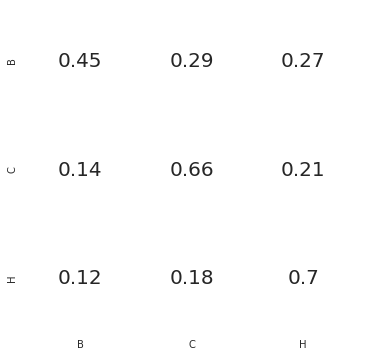

In [ ]:
y_actual = pd.Series(y_train.argmax(axis=1))
y_pred = pd.Series(y_pred.argmax(axis=1))
cm = pd.crosstab(y_actual,y_pred).to_numpy()

cm_norm = np.array([cm[i][j]/cm[i].sum() for i in range(cm.shape[0]) for j in range(cm.shape[1])])
cm_norm = cm_norm.reshape(3,3)

import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


#To use the seaborn heatmap, the confusion matrix array "cm" must be placed into a dataframe
#index specifies the row labels as B, C, H
#columns specifies the column labels as B, C, H
df_cm = pd.DataFrame(cm_norm, index = [i for i in "BCH"],
                  columns = [i for i in "BCH"])


#Setting figure size
plt.figure(figsize = (6,6))

with sns.axes_style('white'):
    sns.heatmap(df_cm,
                cbar=False,
                square=False,
                annot=True,
                annot_kws={"size": 20},
                cmap=ListedColormap(['white']),
                linewidths=0.5)
    sns.set(font_scale=1.8)